### **Identification des thématiques clés lors d’une conversation entre patients et psychologues (NLP)**

**Objectif** : Identifier les principaux sujets abordés dans les conversations en utilisant des techniques de clustering (LDA, NMF, BERTopic).  
Pourquoi c'est intéressant ? Cela permet de mieux comprendre les préoccupations fréquentes et d’adapter les ressources d’aide.

In [120]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import time
import numpy as np


import re
import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split


In [2]:

data = pd.read_parquet("hf://datasets/NickyNicky/nlp-mental-health-conversations/data/train-00000-of-00001.parquet")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [121]:
data.isna().sum()

# Ensure text data is in string format
data['Context'] = data['Context'].astype(str)
data['Response'] = data['Response'].astype(str)

#### Nettoyage des textes

In [37]:
# !pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 9.0 MB/s eta 0:00:00


In [122]:
import contractions #  Étendre les contractions avant de nettoyer le texte . i'm -> i am

def expand_contractions(text):
    return contractions.fix(text)

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def clean_text(text):
    if not isinstance(text, str):  # Vérifier si le texte est une string
        return ""  # Retourner une chaîne vide si None ou autre type
    text = text.lower()  # Minuscule
    text = contractions.fix(text)
    text = re.sub(r'\d+', '', text)  # Supprimer les nombres
    text = re.sub(r'[^\w\s]', '', text)  # Supprimer la ponctuation
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Supprimer les stopwords
    return " ".join(words)

data["Context_cleaned"] = data["Context"].apply(clean_text)
data["Response_cleaned"] = data["Response"].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [123]:
df = data.copy()

In [125]:
vect = CountVectorizer(stop_words='english',max_features=500,lowercase=True, min_df=20, encoding='utf-8')
X = vect.fit_transform(df["Response_cleaned"])
df_X = pd.DataFrame(X.toarray(), columns=vect.get_feature_names_out())


Mots les plus frequents

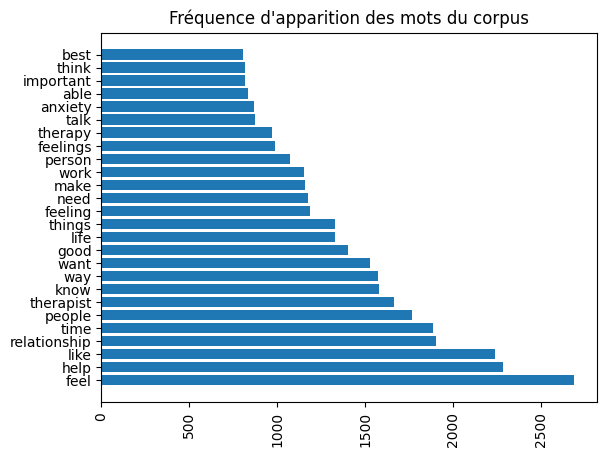

In [163]:
freqs = [(word, X.getcol(idx).sum()) for word, idx in vect.vocabulary_.items()]
freqs = sorted(freqs, key=lambda x: -x[1])

plt.barh([x[0] for x in freqs[:26]], [x[1] for x in freqs[:26]])
plt.xticks(rotation=90)
plt.title("Fréquence d'apparition des mots du corpus")
plt.show()

Nuage des mots

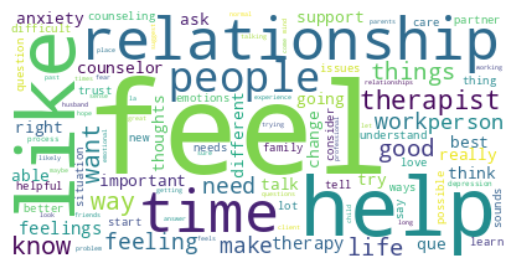

In [127]:
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white", max_words=100).generate_from_frequencies(df_X.T.sum(axis=1))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Detection des thématiques
  - Non-negative Matrix Factorization

In [128]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=6, random_state=123, init="nndsvda", beta_loss="frobenius", alpha_W=0.00005, alpha_H=0.00005, l1_ratio=1)
# train the model and use it to return a matrix where each row represents the topic distribution for a document in the original dataset
start_time = time.time()
nmf_matrix = nmf.fit_transform(X)
print("Temps de calcul :", time.time() - start_time)


terms = vect.get_feature_names_out()
lda_components=nmf.components_

for index, component in enumerate(lda_components):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ", top_terms_list)

Temps de calcul : 0.7401320934295654
Topic 0:  ['like', 'help', 'people', 'want', 'things', 'time', 'know', 'make', 'good', 'need']
Topic 1:  ['que', 'la', 'en', 'tu', 'el', 'es', 'para', 'te', 'si', 'una']
Topic 2:  ['therapist', 'client', 'therapy', 'counselor', 'clients', 'help', 'end', 'counseling', 'work', 'good']
Topic 3:  ['relationship', 'partner', 'need', 'want', 'person', 'work', 'relationships', 'couples', 'trust', 'boyfriend']
Topic 4:  ['feel', 'feeling', 'therapist', 'way', 'like', 'feelings', 'people', 'emotions', 'know', 'comfortable']
Topic 5:  ['thoughts', 'anxiety', 'thought', 'help', 'way', 'negative', 'work', 'positive', 'brain', 'scary']


Fonction pour afficher les thématiques

In [129]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 3, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for index, topic in enumerate(lda_components):
        top_features_key = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_key]
        weights = topic[top_features_key]

        ax = axes[index]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {index +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=30)

    plt.subplots_adjust(top=0.90, bottom=0.1, wspace=0.50, hspace=0.25)
    plt.show()

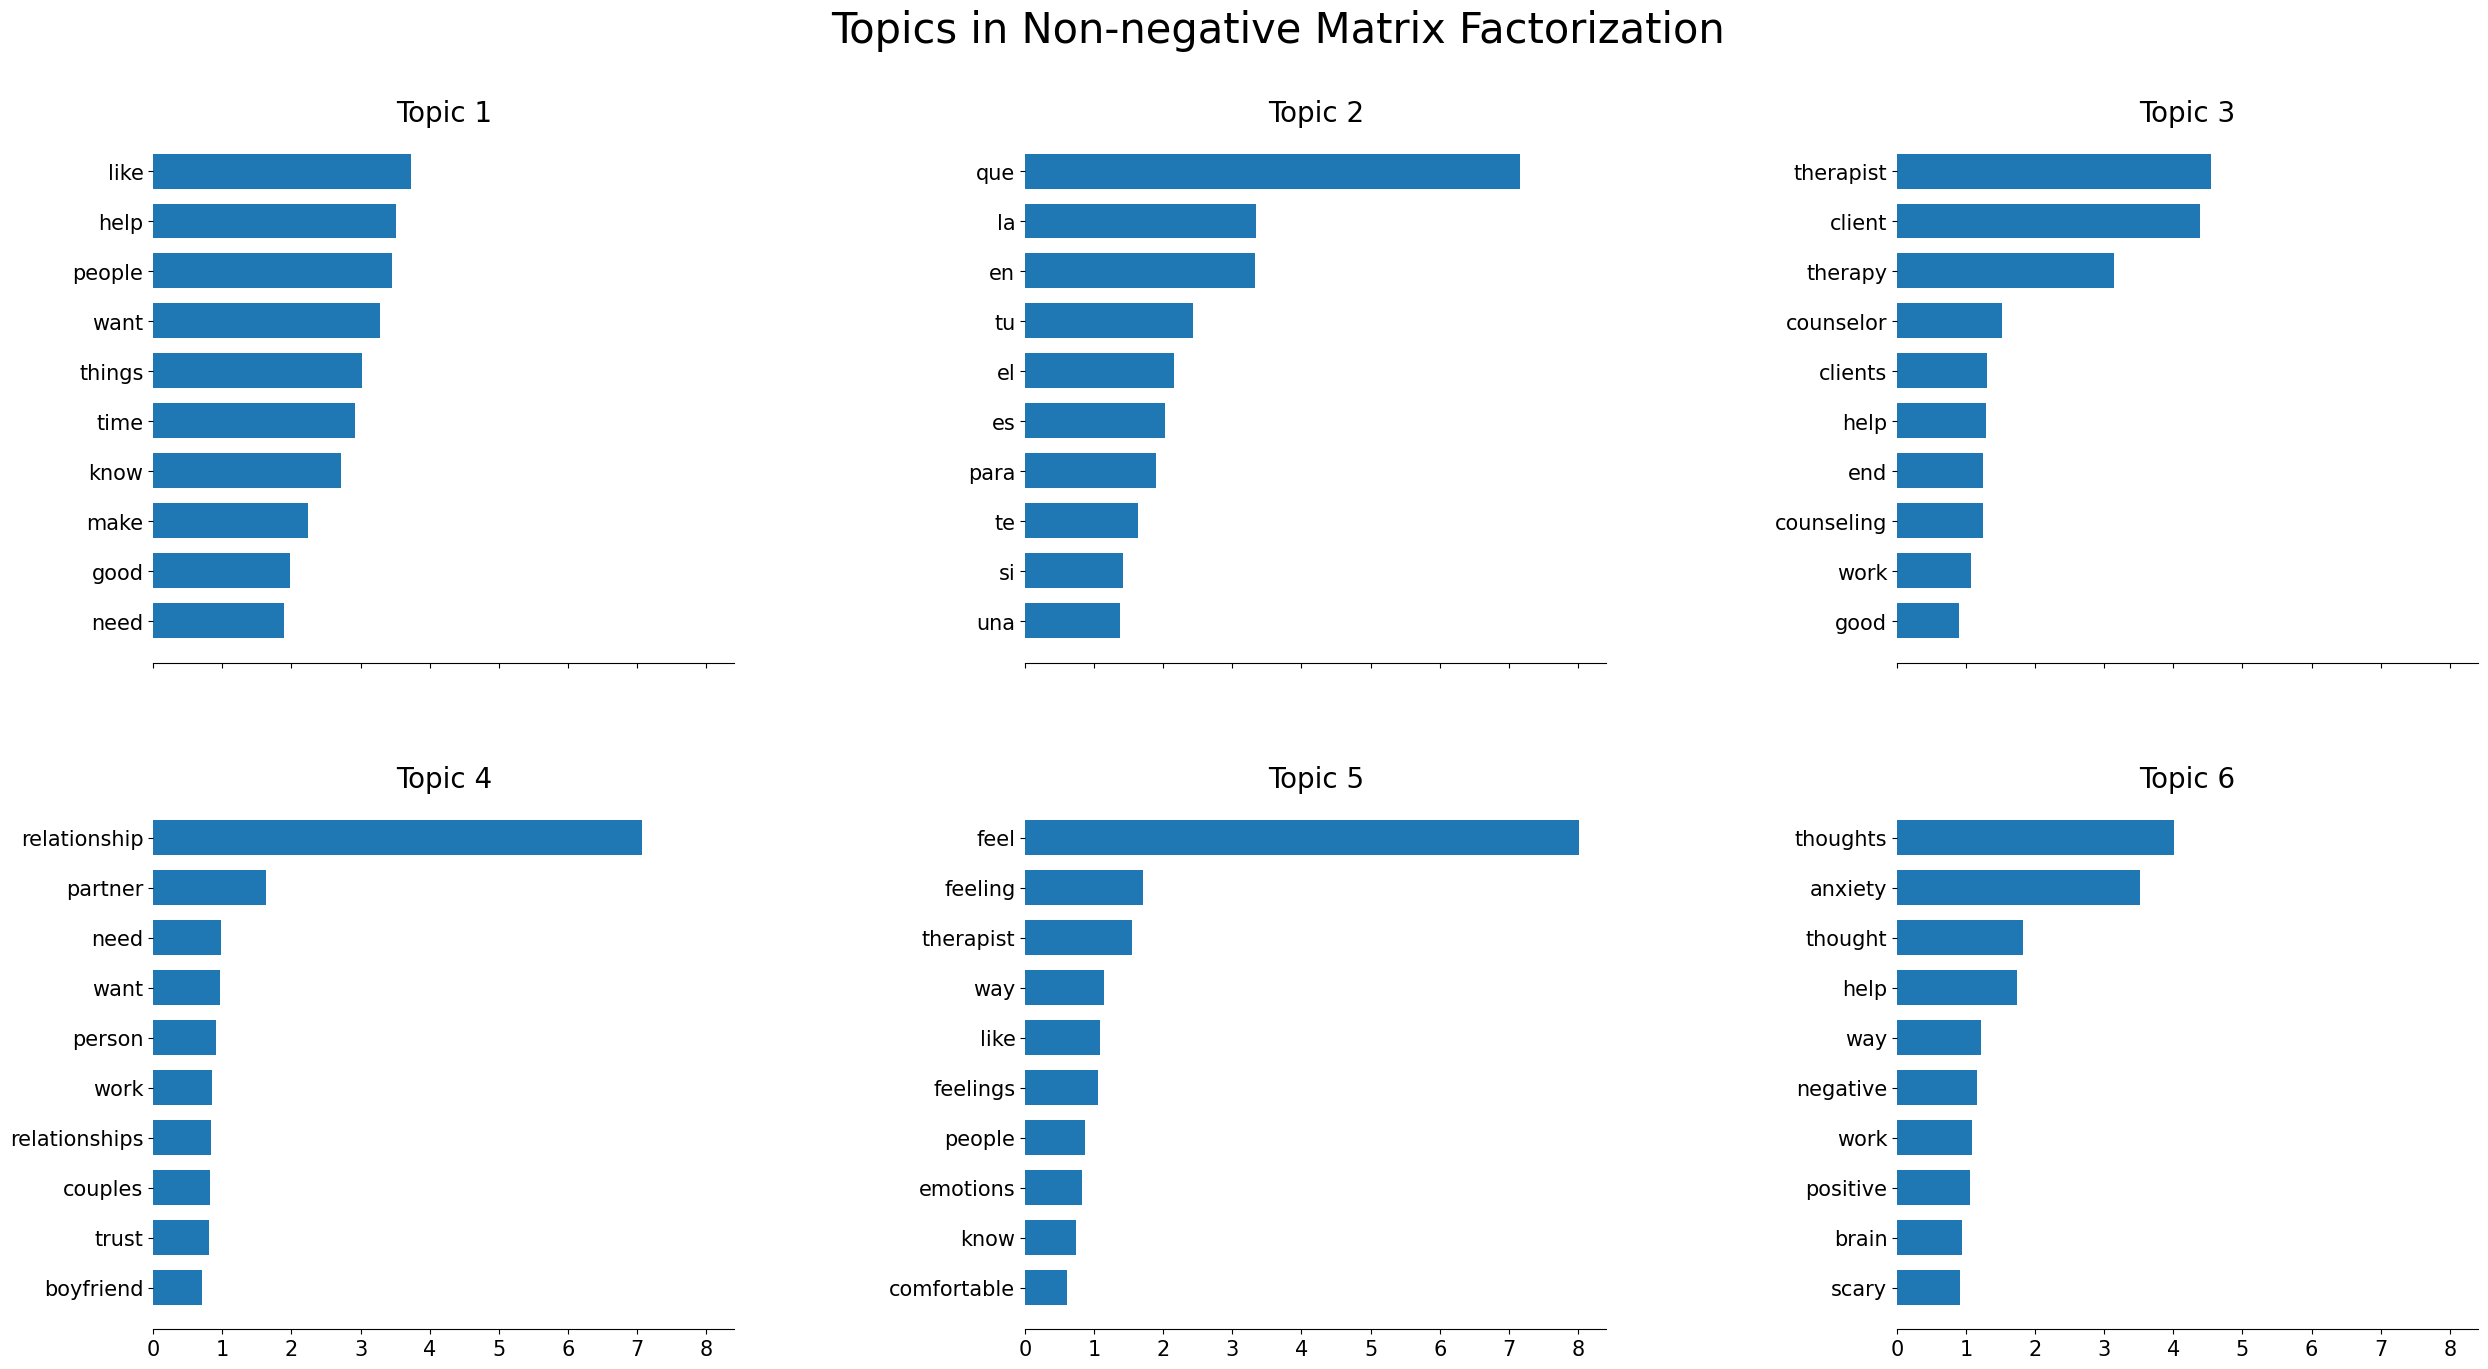

In [160]:
n_top_words = 10
plot_top_words(nmf, terms, n_top_words, "Topics in Non-negative Matrix Factorization")

### Clustering

In [131]:
from sklearn.cluster import KMeans
nclusters = 6
kmeans = KMeans(n_clusters=nclusters, random_state=0)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
from sklearn.metrics import silhouette_score
silhouette_score(X, labels=y_kmeans) # score de silhouette

np.float64(0.10262625740264031)

In [132]:
from sklearn.manifold import TSNE
X_tsne = TSNE(n_components=2, random_state=235, init='random').fit_transform(X)

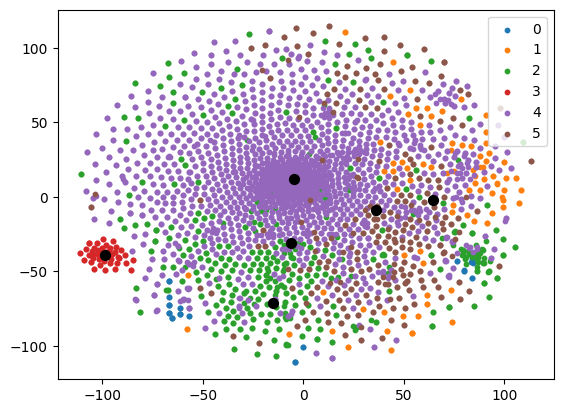

In [133]:
centroids_tsne = []
for i in range(0, nclusters):
    x = X_tsne[y_kmeans==i, 0]
    y = X_tsne[y_kmeans==i, 1]
    x_center = x.mean()
    y_center = y.mean()
    plt.scatter(x, y, label = i, s=10)
    centroids_tsne.append((x_center, y_center))
x_cent, y_cent = zip(*centroids_tsne)
plt.scatter(x_cent, y_cent, s=50, color='k')
plt.legend()
plt.show()

Nuage des mots par cluster

Cluster: 0
Titles


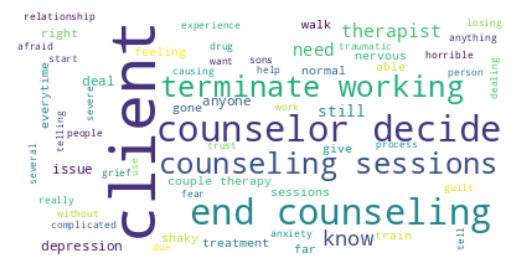

Cluster: 1
Titles


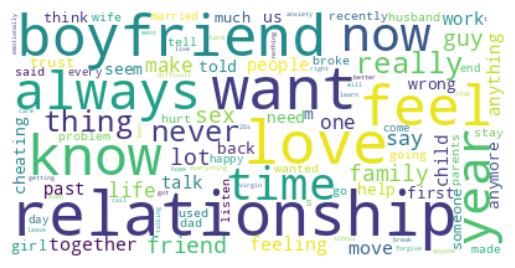

Cluster: 2
Titles


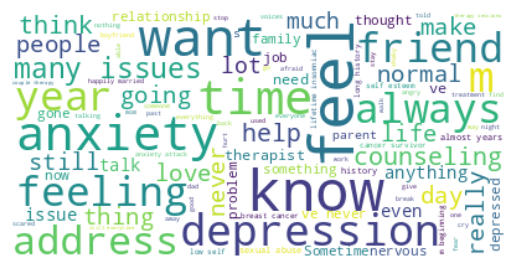

Cluster: 3
Titles


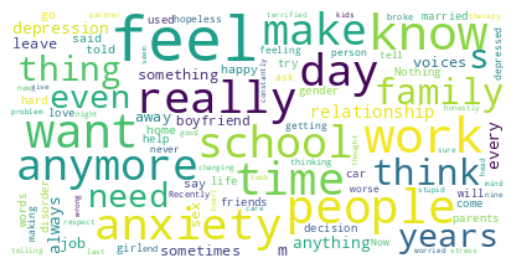

Cluster: 4
Titles


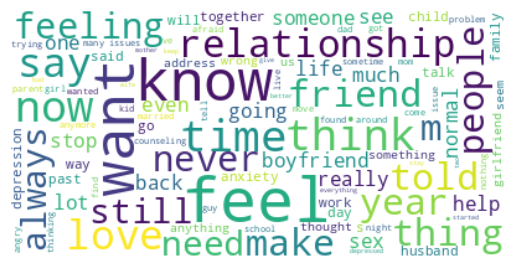

Cluster: 5
Titles


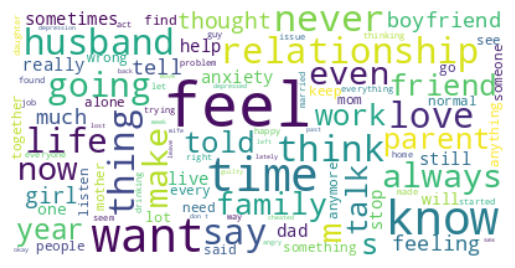

In [134]:
df["Label"] = y_kmeans
for k in range(0, nclusters):
   cl_data = df[df["Label"] == k]
   text = cl_data["Context"].str.cat(sep=' ')
   text = ' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
   print('Cluster: {}'.format(k))
   print('Titles')
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()

Utilisation d'un modele de transformer

## Analyse de sentiment
Dans cette section j'analyse les sentiments des patients

In [3]:
from transformers import pipeline
from transformers import AutoTokenizer


# Choix du modèle
classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


In [136]:
# je trunque le texte ayant un nombre de token superieur à 512
def truncate_text(text, max_length=512):
  if len(text) > max_length:
    return text[:max_length]
  else:
    return text
df["Context_Truncated"] = df["Context"].apply(truncate_text)

df["Sentiment_patient"] = df["Context_Truncated"].apply(lambda x: classifier(x)[0]['label'])

# Affichage les résultats
print(df[["Context", "Sentiment_patient"]].head())

                                             Context Sentiment_patient
0  I'm going through some things with my feelings...          NEGATIVE
1  I'm going through some things with my feelings...          NEGATIVE
2  I'm going through some things with my feelings...          NEGATIVE
3  I'm going through some things with my feelings...          NEGATIVE
4  I'm going through some things with my feelings...          NEGATIVE


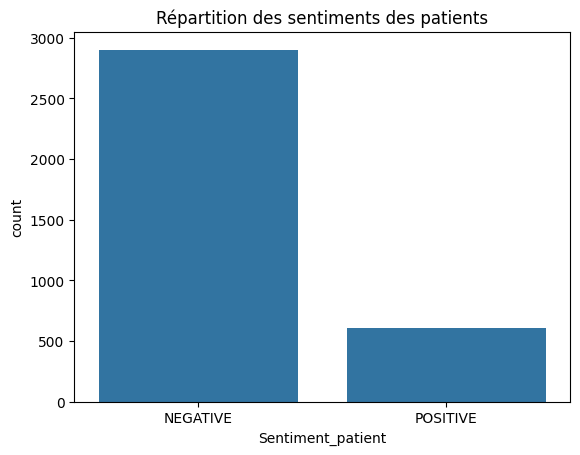

In [137]:
import seaborn as sns
sns.countplot(x="Sentiment_patient", data=df)
plt.title("Répartition des sentiments des patients")
plt.show()

Le graphique ci-dessus montre que le sentiment négatif est très dominant par rapport au sentiment positif. Cela indique que la plupart des patients qui consultent un psychologue rencontrent des problèmes dans leur vie.

In [138]:
df["sentiment_score"] = df["Context_Truncated"].apply(lambda x: classifier(x)[0]['score'])

In [140]:
def compute_signed_score(score, sentiment):
    if sentiment == 'POSITIVE':
        return score
    else:
        return -score
df["sentiment_score"] = df.apply(lambda row: compute_signed_score(row["sentiment_score"], row["Sentiment_patient"]), axis=1)

In [141]:
df.head()

,Context,Response,Context_cleaned,Response_cleaned,Label,Context_Truncated,Sentiment_patient,sentiment_score
0,I'm going through some things with my feelings...,"If everyone thinks you're worthless, then mayb...",going things feelings barely sleep nothing thi...,everyone thinks worthless maybe need find new ...,4,I'm going through some things with my feelings...,NEGATIVE,-0.994835
1,I'm going through some things with my feelings...,"Hello, and thank you for your question and see...",going things feelings barely sleep nothing thi...,hello thank question seeking advice feelings w...,5,I'm going through some things with my feelings...,NEGATIVE,-0.994835
2,I'm going through some things with my feelings...,First thing I'd suggest is getting the sleep y...,going things feelings barely sleep nothing thi...,first thing would suggest getting sleep need i...,4,I'm going through some things with my feelings...,NEGATIVE,-0.994835
3,I'm going through some things with my feelings...,Therapy is essential for those that are feelin...,going things feelings barely sleep nothing thi...,therapy essential feeling depressed worthless ...,2,I'm going through some things with my feelings...,NEGATIVE,-0.994835
4,I'm going through some things with my feelings...,I first want to let you know that you are not ...,going things feelings barely sleep nothing thi...,first want let know alone feelings always some...,4,I'm going through some things with my feelings...,NEGATIVE,-0.994835


Regrouper les conversations en thèmes avec BERTopic

In [ ]:
# pip install bertopic sentence-transformers umap-learn hdbscan

In [25]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import pandas as pd


In [142]:
df.fillna('', inplace=True)
df["Full_Conversation"] = df["Context_cleaned"] + " " + df["Response_cleaned"]
documents = df["Full_Conversation"].tolist()


Modele Bertopic

In [ ]:
modele_embedding = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
modele_topic = BERTopic(embedding_model=modele_embedding, verbose=True)


In [ ]:
topics, probs = modele_topic.fit_transform(documents)

Ajout des topic dans le dataFrrame et affichons les top théme

In [144]:
df["Topic"] = topics
df[["Full_Conversation", "Topic"]].head()

,Full_Conversation,Topic
0,going things feelings barely sleep nothing thi...,31
1,going things feelings barely sleep nothing thi...,31
2,going things feelings barely sleep nothing thi...,31
3,going things feelings barely sleep nothing thi...,31
4,going things feelings barely sleep nothing thi...,31


Liste des top thémes détectés

In [147]:
modele_topic.get_topic_info().head(5)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,511,-1_like_would_may_people,"[like, would, may, people, feel, time, make, s...",[wife always accusing cheating telling things ...
1,0,60,0_therapist_train_treatment_right,"[therapist, train, treatment, right, know, giv...",[know right therapist would know train therapi...
2,1,49,1_anger_angry_emotions_emotion,"[anger, angry, emotions, emotion, coraje, lash...",[longterm girlfriend broke recently says anger...
3,2,48,2_depression_anxiety_medication_illness,"[depression, anxiety, medication, illness, dea...",[dealing depression anxiety number years medic...
4,3,48,3_sex_partner_sexual_sexually,"[sex, partner, sexual, sexually, touch, boyfri...",[terrified sex anymore told sex dangerous even...


Nuage de mots clé par thème

In [156]:
p = modele_topic.visualize_topics()
p.show()

Nuage de mots-clé par thème

In [157]:
p = modele_topic.visualize_barchart(top_n_topics=10, n_words=8, width=300)
p.show()

Ce graphique présente les principaux thèmes identifiés à partir d'une analyse de topics. Chaque sous-graphique représente un topic avec les mots les plus représentatifs et leur score d'importance. On observe que certains thèmes sont liés à des problématiques psychologiques et émotionnelles :


* Le topic 0 est centré sur les séances avec un thérapeute et les traitements.
* Le topic 1 traite des émotions fortes comme la colère et la douleur.

* Le topic 2 semble associé à l'anxiété, depression et medicament (Xanax, attaques de
panique).
* Le topic 3 aborde la sexualité et les relations intimes.

* Le topic 5 est lié aux relations familiales, notamment avec la mère et les sœurs.

* Le topic 6 évoque des problématiques familiales et le pardon.

* Le topic 7 traite des relations de fraternité.

* Le topic 8 concerne des troubles de l'audition et de la santé mentale.

* Le topic 9 est lié la prise de drogue et alcol


### Analyse approfondis de chaque topic

In [150]:
modele_topic.get_topic(3)

[('sex', np.float64(0.05294495742708892)),
 ('partner', np.float64(0.02794708376809324)),
 ('sexual', np.float64(0.019314898198914736)),
 ('sexually', np.float64(0.019145065451315297)),
 ('touch', np.float64(0.016711131190096446)),
 ('boyfriend', np.float64(0.01575315354633523)),
 ('sexo', np.float64(0.015677706621629674)),
 ('porn', np.float64(0.013863260380049059)),
 ('body', np.float64(0.012791500850721086)),
 ('protection', np.float64(0.012491528161223182))]

### Retrouvé les topics liés à un thème precis

In [151]:
modele_topic.find_topics("stress", top_n=6)

([132, 98, 53, 57, 68, 74],
 [np.float32(0.5934104),
  np.float32(0.46352977),
  np.float32(0.4601534),
  np.float32(0.45954102),
  np.float32(0.45726478),
  np.float32(0.4449334)])

On constate que le thème lié au stress apparaît dans les topics[132, 98, 53, 57, 68, 74], etc. Le sujet du stress est principalement abordé dans le topic 128. Ce qui serait très intéressant, ce serait d'afficher la conversation

### Affiche les conversation les conversation lié à un ou plusieurs topics

In [158]:
modele_topic.get_representative_docs(132)

['need help dealing stress handle feel less stressed part handling stress making sure perception stress accurate sometimes stress seem really one thing encourage clients ask stressor really simplifying stress key minimizing stress leads feeling less stressed',
 'need help knowing deal stress something different works usthere outward answers selfpampering making home work environment pleasant possiblea deeper level way decrease stress exercise alternative practices like yoga tai chiif stress deeply rooted temporarily feeling irritated days give time reflect clarify meaning stress youselfunderstanding appreciating efforts know may decrease stress focused attentive influence overall make good decisions naturally ones decrease stress much possible',
 'need help knowing deal stress something different works usthere outward answers selfpampering making home work environment pleasant possiblea deeper level way decrease stress exercise alternative practices like yoga tai chiif stress deeply ro

### Visualisation Hiérarchique

In [159]:
p = modele_topic.visualize_hierarchy(top_n_topics=60)
p.show()

In [155]:
df_hierarachy = pd.DataFrame(modele_topic.hierarchical_topics(documents))
df_hierarachy.head()

100%|██████████| 135/135 [00:00<00:00, 230.92it/s]


,Parent_ID,Parent_Name,Topics,Child_Left_ID,Child_Left_Name,Child_Right_ID,Child_Right_Name,Distance
134,270,feel_like_help_would_relationship,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",267,client_counseling_therapy_therapist_sessions,269,feel_relationship_like_want_time,1.835620
133,269,feel_relationship_like_want_time,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16...",268,anxiety_que_help_depression_de,265,relationship_want_love_sex_know,1.638076
132,268,anxiety_que_help_depression_de,"[2, 8, 9, 14, 17, 21, 26, 31, 33, 35, 36, 47, ...",263,anxiety_help_thoughts_depression_may,211,que_de_en_tu_la,1.589269
131,267,client_counseling_therapy_therapist_sessions,"[0, 12, 13, 18, 19, 20, 25, 27, 39, 42, 48, 83...",137,history_address_issues_counseling_breast,266,client_therapy_therapist_sessions_counselor,1.534506
130,266,client_therapy_therapist_sessions_counselor,"[0, 12, 13, 20, 25, 27, 39, 42, 48, 88, 89, 115]",142,nervous_shaky_everytime_sessions_still,262,client_counselor_therapist_counseling_therapy,1.421458
